# **Data Mining Project** 
# Task 4: TimeSeries
Pistolesi Veronica, Poli Francesca

## Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy
import matplotlib
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

from collections import defaultdict
from scipy.stats import pearsonr
from scipy.stats import entropy
from datetime import datetime

In [ ]:
!pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tqdm import tqdm

In [ ]:
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict, LearningShapelets
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [ ]:
#metrics computed on the test set
from sklearn.metrics import classification_report
def report_scores(ts_label, test_pred):
    print(classification_report(ts_label, 
                            test_pred, 
                            target_names=['human (0)', 'bot (1)']))

## Data Loading and creation of useful lists

In [ ]:
tweets_scores = pd.read_csv('/content/drive/Shareddrives/DataMining/dataset/tweets_scores.csv', lineterminator='\n', index_col=False)

In [ ]:
users = pd.read_csv('/content/drive/Shareddrives/DataMining/dataset/users_profile.csv', lineterminator='\n', index_col=False)

In [ ]:
users = users[['user_id', 'bot']]

In [ ]:
tweets_scores.head()

user_id  created_at  SuccessScore  bot
0   722623  2019-01-01     -1.000000    0
1   722623  2019-01-02     -1.000000    0
2   722623  2019-01-03      1.549296    0
3   722623  2019-01-04   1626.393443    0
4   722623  2019-01-05      1.818182    0

In [ ]:
scores = tweets_scores.groupby('user_id')['SuccessScore'].apply(list)
scores.head()

user_id
722623     [-1.0, -1.0, 1.5492957746478877, 1626.39344262...
755746     [-1.0, -1.0, 0.0, 0.0, 0.0, 0.1639344262295082...
806975     [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....
887281     [-1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0...
1382561    [-1.0, -1.0, 60.0940070505288, 0.4480651731160...
Name: SuccessScore, dtype: object

In [ ]:
scores = scores.to_frame()

In [ ]:
ts_users = scores.merge(users, on='user_id')

In [ ]:
ts_users.head()

user_id                                       SuccessScore  bot
0   722623  [-1.0, -1.0, 1.5492957746478877, 1626.39344262...    0
1   755746  [-1.0, -1.0, 0.0, 0.0, 0.0, 0.1639344262295082...    0
2   806975  [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....    0
3   887281  [-1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0...    0
4  1382561  [-1.0, -1.0, 60.0940070505288, 0.4480651731160...    0

## Denoising and Normalizing TimeSeries

In [ ]:
X = ts_users["SuccessScore"].values
y = ts_users["bot"].values
y = np.int_(y)

In [ ]:
ts_all = []
for x in X:
  ts_all.append(pd.Series(x))

In [ ]:
# Time Series before denoising and normalization
X = ts_all  

In [ ]:
#Removing noise using a slinding window
def remove_noise(ts,w):
    #ts = ((ts - ts.mean())/ts.std()).rolling(window=w).mean()
    ts = ts.rolling(window=w, min_periods=1).mean()
    return ts
# Remove noise over all the dataset
ts_w7 = []
ts_w14 = []
ts_w30 = []
for ts in tqdm(X):
  ts_w7.append(remove_noise(ts, 7))
  ts_w14.append(remove_noise(ts, 14))
  ts_w30.append(remove_noise(ts, 30))



100%|██████████| 6787/6787 [00:09<00:00, 686.46it/s]


In [ ]:
# Time series after denoising
Xw7 = ts_w7     
Xw14 = ts_w14
Xw30 = ts_w30

In [ ]:
#X = ts_all

In [ ]:
#ts_all[2:4]

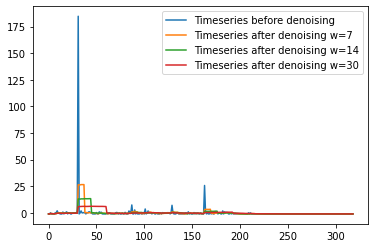

In [ ]:
ts_ex = X[5]
ts_ex_w7 = Xw7[5]
ts_ex_w14 = Xw14[5]
ts_ex_w30 = Xw30[5]

plt.plot(ts_ex, label="Timeseries before denoising")
plt.plot(ts_ex_w7, label="Timeseries after denoising w=7")
plt.plot(ts_ex_w14, label="Timeseries after denoising w=14")
plt.plot(ts_ex_w30, label="Timeseries after denoising w=30")
plt.legend()
plt.show()

In [ ]:
#Normalization
from tslearn.preprocessing import TimeSeriesScalerMinMax
scaler = TimeSeriesScalerMinMax(value_range=(0.0, 1.))  

def ts_norm(ts):
  ts_reshaped = ts.values.reshape(1, -1)
  return scaler.fit_transform(ts_reshaped).flatten()

In [ ]:
# Time series after normalization
ts_ex_n = ts_norm(ts_ex)
ts_ex_n7 = ts_norm(ts_ex_w7)
ts_ex_n14 = ts_norm(ts_ex_w14)
ts_ex_n30 = ts_norm(ts_ex_w30)

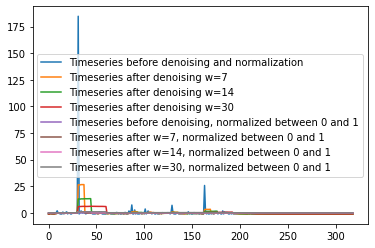

In [ ]:
plt.plot(ts_ex, label="Timeseries before denoising and normalization")
plt.plot(ts_ex_w7, label="Timeseries after denoising w=7")
plt.plot(ts_ex_w14, label="Timeseries after denoising w=14")
plt.plot(ts_ex_w30, label="Timeseries after denoising w=30")

plt.plot(ts_ex_n, label="Timeseries before denoising, normalized between 0 and 1")
plt.plot(ts_ex_n7, label="Timeseries after w=7, normalized between 0 and 1")
plt.plot(ts_ex_n14, label="Timeseries after w=14, normalized between 0 and 1")
plt.plot(ts_ex_n30, label="Timeseries after w=30, normalized between 0 and 1")

plt.legend()
plt.show()

In [ ]:
ts_n = []
ts_n7 = []
ts_n14 = []
ts_n30 = []

# Normalize all the dataset
for ts in tqdm(X):
  ts_n.append(ts_norm(ts))
for ts in tqdm(Xw7):
  ts_n7.append(ts_norm(ts))
for ts in tqdm(Xw14):
  ts_n14.append(ts_norm(ts))
for ts in tqdm(Xw30):
  ts_n30.append(ts_norm(ts))

100%|██████████| 6787/6787 [00:04<00:00, 1682.26it/s]


In [ ]:
# Time series after normalization
Xn = ts_n
Xwn7 = ts_n7   # and denoising w=7
Xwn14 = ts_n14   # and denoising w=14
Xwn30 = ts_n30   # and denoising w=30

In [ ]:
X = np.array(X)   # original time series
Xn = np.array(Xn)   # normalized time series
Xw7 = np.array(Xw7)   # denoised w=7 time series
Xwn7 = np.array(Xwn7)   # denoised w=7 and normalized time series
Xw14 = np.array(Xw14)   # denoised w=14 time series
Xwn14 = np.array(Xwn14)   # denoised w=14 and normalized time series
Xw30 = np.array(Xw30)   # denoised w=30 time series
Xwn30 = np.array(Xwn30)   # denoised w=30 and normalized time series

In [ ]:
X.shape

(6787, 319)

# Classification X

In [ ]:
# X = X

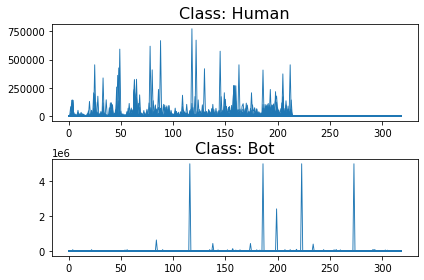

In [ ]:
plt.figure()
for i, classe in enumerate(['Human', 'Bot']):
    plt.subplot(2, 1, i + 1)
    for x in np.array(X)[y == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5429, 319)
(1358, 319)
(5429,)
(1358,)


In [ ]:
# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=X_train.shape[0],
                                                       ts_sz=X_train.shape[1],
                                                       n_classes=2,
                                                       l=0.1,
                                                       r=1)

# Define the model using parameters provided by the authors (except that we
# use fewer iterations here)
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            optimizer=tf.optimizers.Adam(.001), #.001 #
                            batch_size=16,
                           # weight_regularizer=.0001,  # [0.1,0.01, 0.001, 0.0001]
                            max_iter=25,
                            total_lengths=3, #[3, 5]
                            random_state=42,
                            verbose=1)
shp_clf.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Epoch 1/25
340/340 [==============================] - 4s 6ms/step - loss: 159614912.0000 - binary_accuracy: 0.6167 - binary_crossentropy: 159614912.0000
Epoch 2/25
340/340 [==============================] - 2s 6ms/step - loss: 24327908.0000 - binary_accuracy: 0.6215 - binary_crossentropy: 24327908.0000
Epoch 3/25
340/340 [==============================] - 2s 5ms/step - loss: 27335876.0000 - binary_accuracy: 0.6154 - binary_crossentropy: 27335876.0000
Epoch 4/25
340/340 [==============================] - 2s 6ms/step - loss: 31990292.0000 - binary_accuracy: 0.6056 - binary_crossentropy: 31990292.0000
Epoch 5/25
340/340 [==============================] - 2s 6ms/step - loss: 25298836.0000 - binary_accuracy: 0.6202 - binary_crossentropy: 25298836.0000
Epoch 6/25
340/340 [==============================] - 2s 6ms/step - loss: 25930632.0000 - binary_accuracy: 0.6220 - binary_crossentropy: 25930632.0000
Epoch 7/25
340/340 [==============================] - 2s 6ms/step - loss: 23183320.0000 - bi

LearningShapelets(batch_size=16, max_iter=25, n_shapelets_per_size={31: 6},
                  optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f0a40d8b670>,
                  random_state=42, verbose=1)

In [ ]:
pred = shp_clf.predict(X_test)

85/85 [==============================] - 1s 5ms/step


In [ ]:
#compute the performance of the model
report_scores(y_test, pred)

              precision    recall  f1-score   support

   human (0)       0.84      0.34      0.48       584
     bot (1)       0.65      0.95      0.78       774

    accuracy                           0.69      1358
   macro avg       0.75      0.64      0.63      1358
weighted avg       0.73      0.69      0.65      1358



In [ ]:
#compute confusion matrix
cm = confusion_matrix(y_test, pred)
cm

array([[196, 388],
       [ 38, 736]])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


85/85 [==============================] - 0s 4ms/step


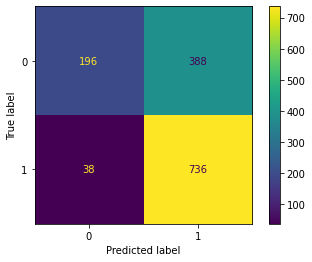

In [ ]:
#it is possible to plot the confusion matrix 
plot_confusion_matrix(shp_clf, X_test, y_test)
plt.show() 

In [ ]:
pred

array([1, 1, 1, ..., 1, 1, 1])

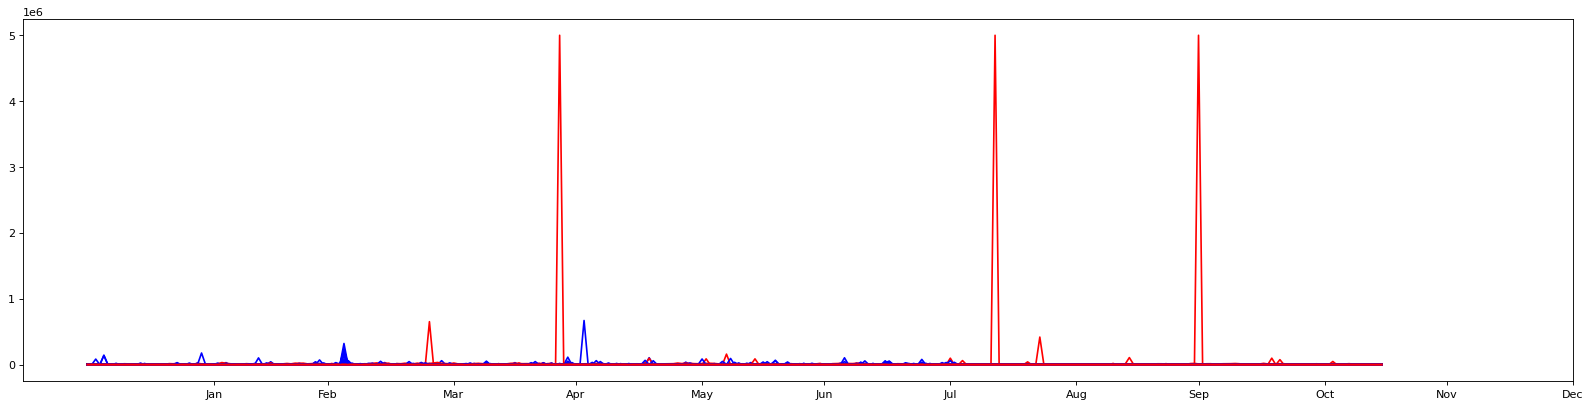

In [ ]:
# plot test set TimeSeries (real colors)
figure(figsize=(25, 6), dpi=80)

for i in range(len(X_test)):

  if y_test[i] == 0:
    col = "b"
  else:
    col = "r"

  plt.plot(X_test[i], color=col)

#plt.ylim(-1,500000)
plt.xticks([31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

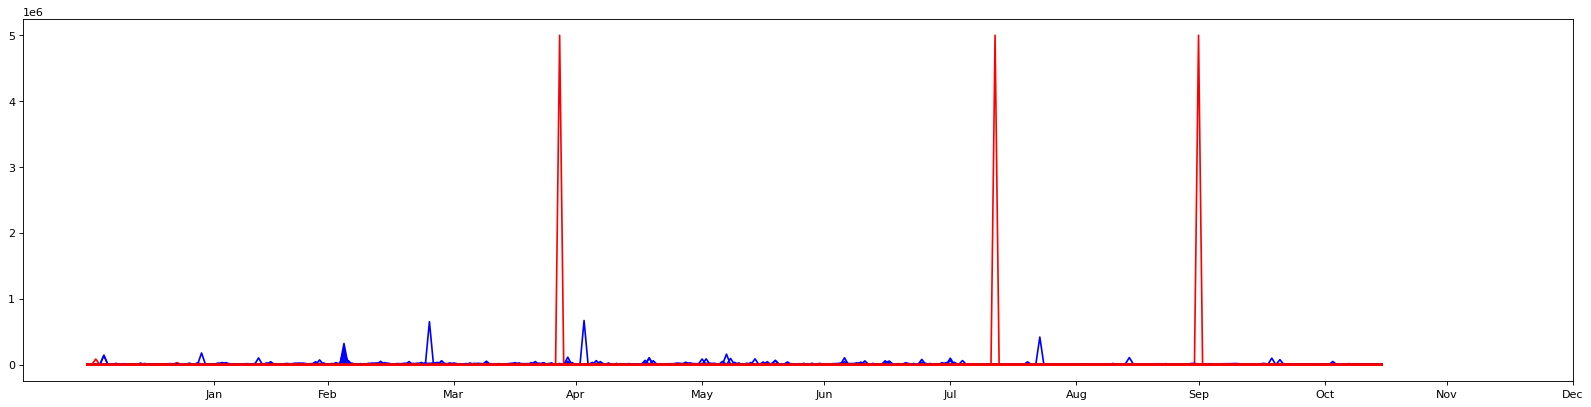

In [ ]:
# plot test set TimeSeries (predicted colors)
figure(figsize=(25, 6), dpi=80)

for i in range(len(X_test)):

  if pred[i] == 0:
    col = "b"
  else:
    col = "r"

  plt.plot(X_test[i], color=col)

#plt.ylim(-1,500000)
plt.xticks([31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

In [ ]:
shp_clf.shapelets_as_time_series_.shape

(6, 31, 1)

In [ ]:
shp_clf.shapelets_[0].shape

(31, 1)

In [ ]:
# Select three shapelets
sel_shapelets = np.asarray([shp_clf.shapelets_[0], 
                        shp_clf.shapelets_[1], 
                        shp_clf.shapelets_[2],
                        shp_clf.shapelets_[3],
                        shp_clf.shapelets_[4],
                        shp_clf.shapelets_[5]])

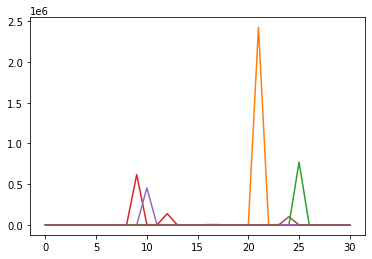

In [ ]:
plt.plot(sel_shapelets[0])
plt.plot(sel_shapelets[1])
plt.plot(sel_shapelets[2])
plt.plot(sel_shapelets[3])
plt.plot(sel_shapelets[4])
plt.plot(sel_shapelets[5])

plt.show()

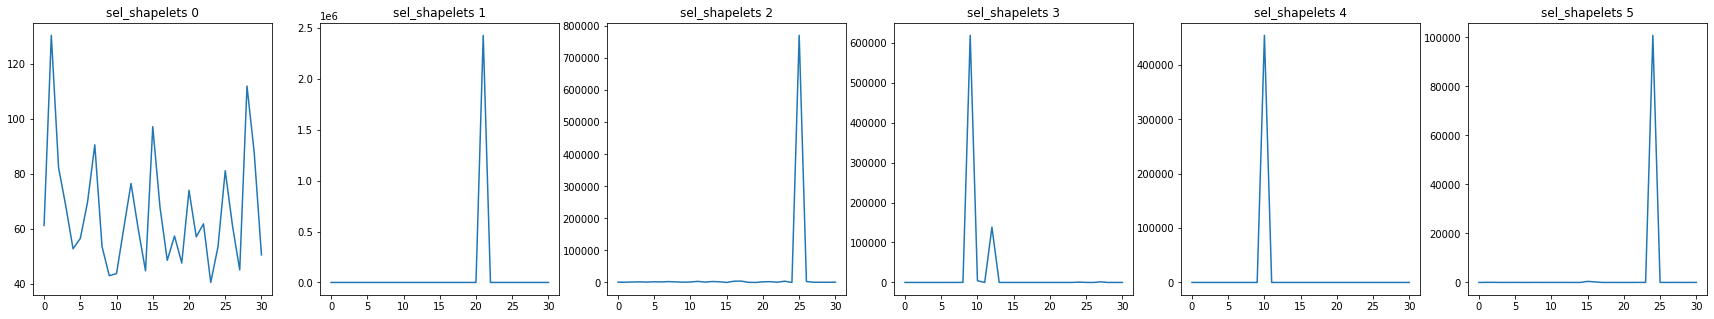

In [ ]:
# sel_shapelets plots
f, axs = plt.subplots(nrows=1, ncols=len(sel_shapelets), figsize=(30,5))

for i in range(len(sel_shapelets)):
    axs[i].plot(sel_shapelets[i])
    axs[i].set_title('sel_shapelets '+ str(i))

plt.show()

# Classification Xn

In [ ]:
X = Xn

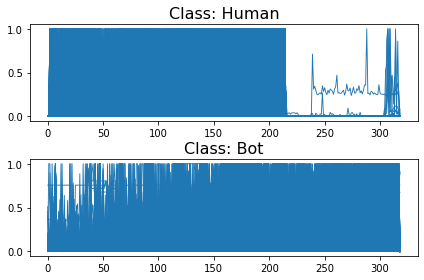

In [ ]:
plt.figure()
for i, classe in enumerate(['Human', 'Bot']):
    plt.subplot(2, 1, i + 1)
    for x in np.array(X)[y == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5429, 319)
(1358, 319)
(5429,)
(1358,)


In [ ]:
# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=X_train.shape[0],
                                                       ts_sz=X_train.shape[1],
                                                       n_classes=2,
                                                       l=0.1,
                                                       r=1)

# Define the model using parameters provided by the authors (except that we
# use fewer iterations here)
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            optimizer=tf.optimizers.Adam(.001), #.001 #
                            batch_size=16,
                           # weight_regularizer=.0001,  # [0.1,0.01, 0.001, 0.0001]
                            max_iter=25,
                            total_lengths=3, #[3, 5]
                            random_state=42,
                            verbose=1)
shp_clf.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Epoch 1/25
340/340 [==============================] - 3s 6ms/step - loss: 0.6878 - binary_accuracy: 0.5710 - binary_crossentropy: 0.6878
Epoch 2/25
340/340 [==============================] - 2s 6ms/step - loss: 0.6844 - binary_accuracy: 0.5712 - binary_crossentropy: 0.6844
Epoch 3/25
340/340 [==============================] - 2s 5ms/step - loss: 0.6826 - binary_accuracy: 0.5712 - binary_crossentropy: 0.6826
Epoch 4/25
340/340 [==============================] - 2s 6ms/step - loss: 0.6807 - binary_accuracy: 0.5712 - binary_crossentropy: 0.6807
Epoch 5/25
340/340 [==============================] - 2s 6ms/step - loss: 0.6777 - binary_accuracy: 0.5712 - binary_crossentropy: 0.6777
Epoch 6/25
340/340 [==============================] - 2s 6ms/step - loss: 0.6724 - binary_accuracy: 0.5712 - binary_crossentropy: 0.6724
Epoch 7/25
340/340 [==============================] - 2s 6ms/step - loss: 0.6659 - binary_accuracy: 0.5712 - binary_crossentropy: 0.6659
Epoch 8/25
340/340 [=====================

LearningShapelets(batch_size=16, max_iter=25, n_shapelets_per_size={31: 6},
                  optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f0a445fc490>,
                  random_state=42, verbose=1)

In [ ]:
pred = shp_clf.predict(X_test)

85/85 [==============================] - 1s 8ms/step


In [ ]:
#compute the performance of the model
report_scores(y_test, pred)

              precision    recall  f1-score   support

   human (0)       0.65      0.58      0.61       584
     bot (1)       0.71      0.76      0.73       774

    accuracy                           0.68      1358
   macro avg       0.68      0.67      0.67      1358
weighted avg       0.68      0.68      0.68      1358



In [ ]:
#compute confusion matrix
cm = confusion_matrix(y_test, pred)
cm

array([[340, 244],
       [185, 589]])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


85/85 [==============================] - 1s 7ms/step


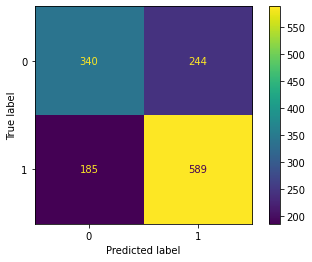

In [ ]:
#it is possible to plot the confusion matrix 
plot_confusion_matrix(shp_clf, X_test, y_test)
plt.show() 

In [ ]:
pred

array([0, 1, 1, ..., 1, 0, 1])

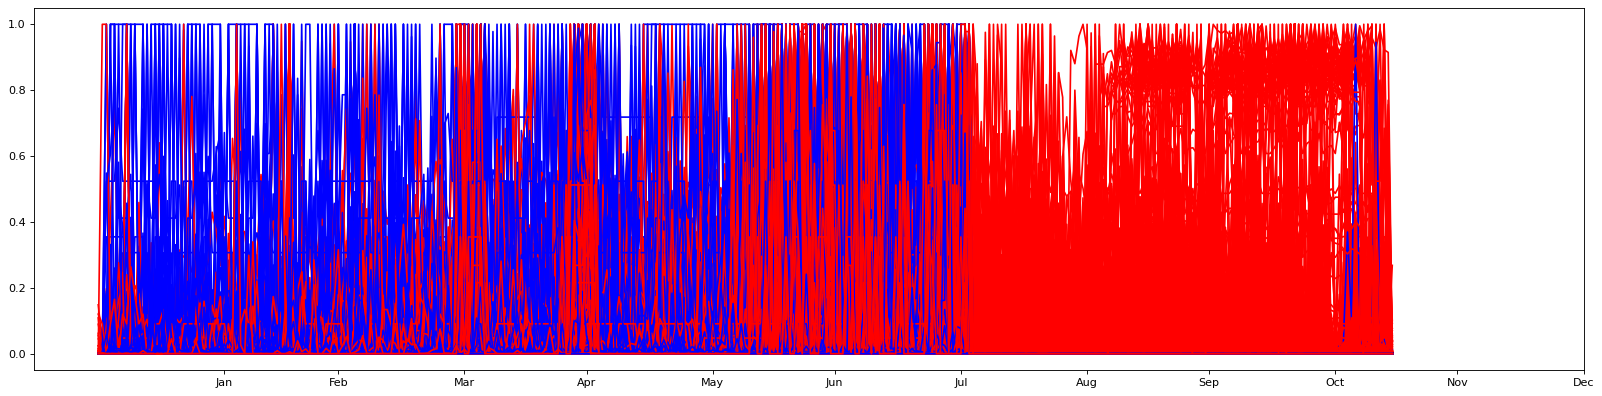

In [ ]:
# plot test set TimeSeries (real colors)
figure(figsize=(25, 6), dpi=80)

for i in range(len(X_test)):

  if y_test[i] == 0:
    col = "b"
  else:
    col = "r"

  plt.plot(X_test[i], color=col)

#plt.ylim(-1,500000)
plt.xticks([31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

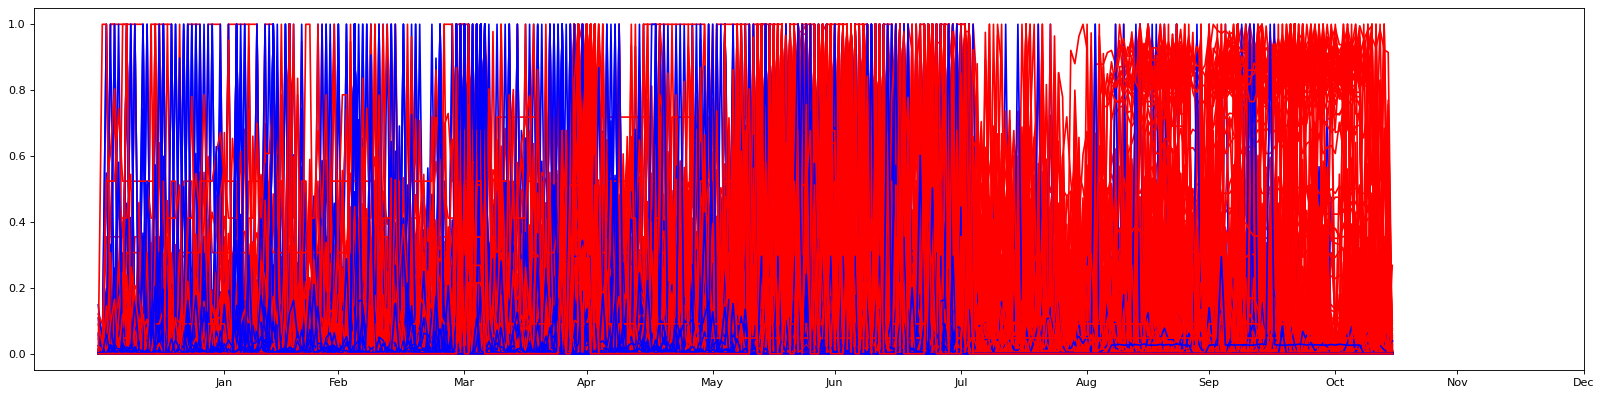

In [ ]:
# plot test set TimeSeries (predicted colors)
figure(figsize=(25, 6), dpi=80)

for i in range(len(X_test)):

  if pred[i] == 0:
    col = "b"
  else:
    col = "r"

  plt.plot(X_test[i], color=col)

#plt.ylim(-1,500000)
plt.xticks([31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

In [ ]:
shp_clf.shapelets_as_time_series_.shape

(6, 31, 1)

In [ ]:
shp_clf.shapelets_[0].shape

(31, 1)

In [ ]:
# Select three shapelets
sel_shapelets = np.asarray([shp_clf.shapelets_[0], 
                        shp_clf.shapelets_[1], 
                        shp_clf.shapelets_[2],
                        shp_clf.shapelets_[3],
                        shp_clf.shapelets_[4],
                        shp_clf.shapelets_[5]])

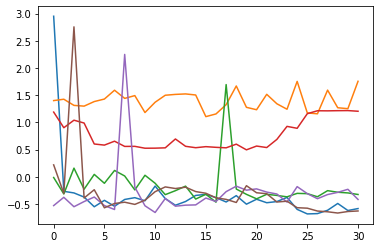

In [ ]:
plt.plot(sel_shapelets[0])
plt.plot(sel_shapelets[1])
plt.plot(sel_shapelets[2])
plt.plot(sel_shapelets[3])
plt.plot(sel_shapelets[4])
plt.plot(sel_shapelets[5])

plt.show()

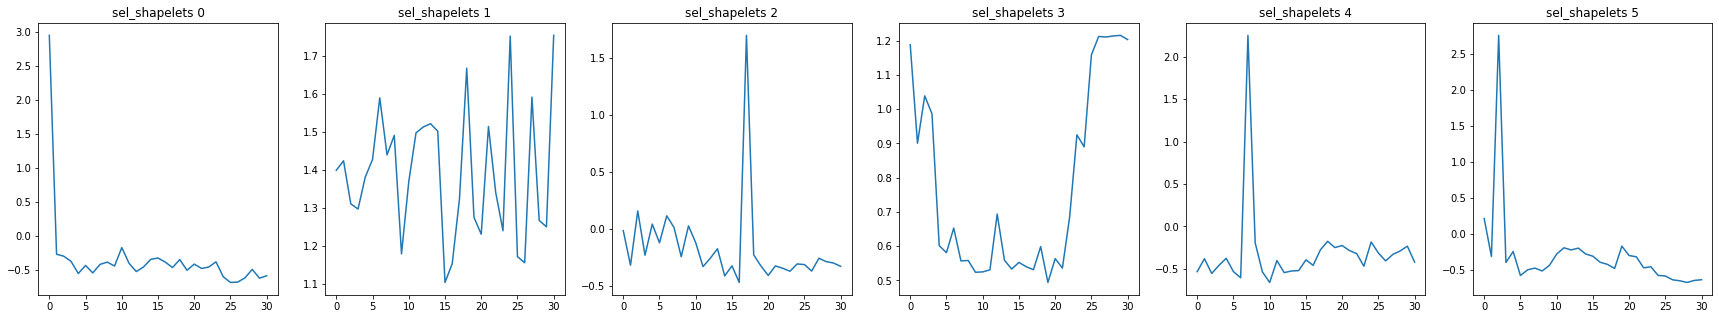

In [ ]:
# sel_shapelets plots
f, axs = plt.subplots(nrows=1, ncols=len(sel_shapelets), figsize=(30,5))

for i in range(len(sel_shapelets)):
    axs[i].plot(sel_shapelets[i])
    axs[i].set_title('sel_shapelets '+ str(i))

plt.show()

# Classification Xw7

In [ ]:
X = Xw7

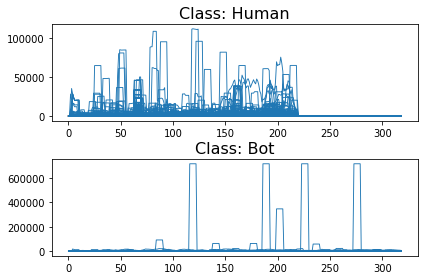

In [ ]:
plt.figure()
for i, classe in enumerate(['Human', 'Bot']):
    plt.subplot(2, 1, i + 1)
    for x in np.array(X)[y == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5429, 319)
(1358, 319)
(5429,)
(1358,)


In [ ]:
# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=X_train.shape[0],
                                                       ts_sz=X_train.shape[1],
                                                       n_classes=2,
                                                       l=0.1,
                                                       r=1)

# Define the model using parameters provided by the authors (except that we
# use fewer iterations here)
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            optimizer=tf.optimizers.Adam(.001), #.001 #
                            batch_size=16,
                           # weight_regularizer=.0001,  # [0.1,0.01, 0.001, 0.0001]
                            max_iter=25,
                            total_lengths=3, #[3, 5]
                            random_state=42,
                            verbose=1)
shp_clf.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Epoch 1/25
340/340 [==============================] - 3s 6ms/step - loss: 2629260288.0000 - binary_accuracy: 0.5537 - binary_crossentropy: 2629260288.0000
Epoch 2/25
340/340 [==============================] - 2s 6ms/step - loss: 16551620.0000 - binary_accuracy: 0.4561 - binary_crossentropy: 16551620.0000
Epoch 3/25
340/340 [==============================] - 2s 6ms/step - loss: 15898232.0000 - binary_accuracy: 0.4585 - binary_crossentropy: 15898232.0000
Epoch 4/25
340/340 [==============================] - 2s 6ms/step - loss: 15110222.0000 - binary_accuracy: 0.4487 - binary_crossentropy: 15110222.0000
Epoch 5/25
340/340 [==============================] - 2s 6ms/step - loss: 15498371.0000 - binary_accuracy: 0.4563 - binary_crossentropy: 15498371.0000
Epoch 6/25
340/340 [==============================] - 2s 6ms/step - loss: 14723496.0000 - binary_accuracy: 0.4529 - binary_crossentropy: 14723496.0000
Epoch 7/25
340/340 [==============================] - 2s 6ms/step - loss: 14439560.0000 - 

LearningShapelets(batch_size=16, max_iter=25, n_shapelets_per_size={31: 6},
                  optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f0a37e1fcd0>,
                  random_state=42, verbose=1)

In [ ]:
pred = shp_clf.predict(X_test)

85/85 [==============================] - 0s 4ms/step


In [ ]:
#compute the performance of the model
report_scores(y_test, pred)

              precision    recall  f1-score   support

   human (0)       0.42      0.89      0.57       584
     bot (1)       0.47      0.07      0.13       774

    accuracy                           0.43      1358
   macro avg       0.45      0.48      0.35      1358
weighted avg       0.45      0.43      0.32      1358



In [ ]:
#compute confusion matrix
cm = confusion_matrix(y_test, pred)
cm

array([[522,  62],
       [718,  56]])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


85/85 [==============================] - 0s 4ms/step


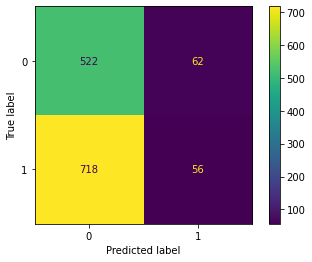

In [ ]:
#it is possible to plot the confusion matrix 
plot_confusion_matrix(shp_clf, X_test, y_test)
plt.show() 

In [ ]:
pred

array([0, 1, 0, ..., 0, 0, 0])

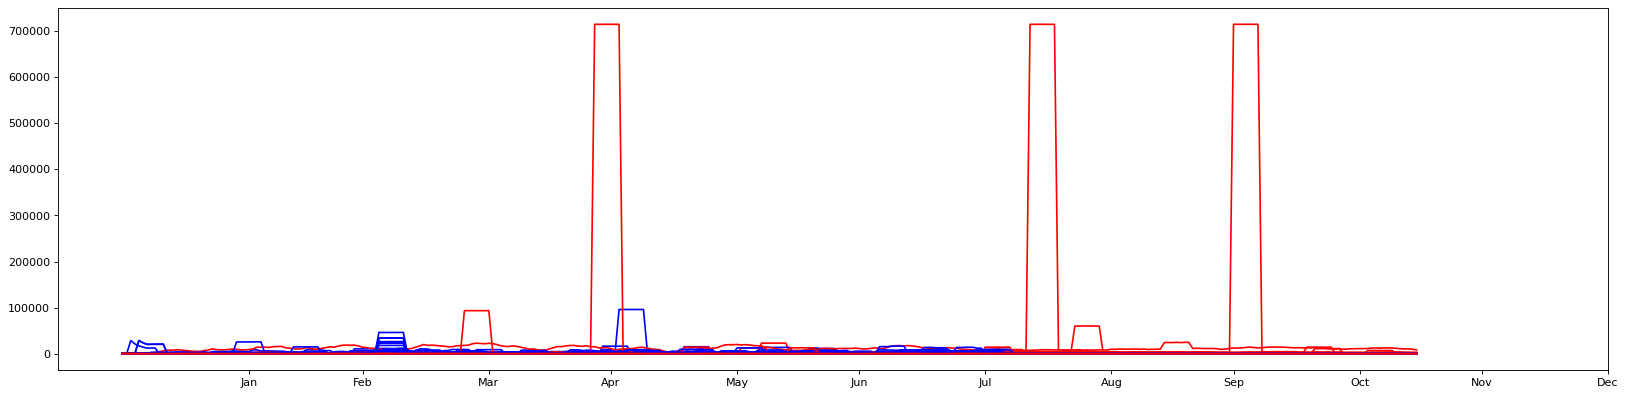

In [ ]:
# plot test set TimeSeries (real colors)
figure(figsize=(25, 6), dpi=80)

for i in range(len(X_test)):

  if y_test[i] == 0:
    col = "b"
  else:
    col = "r"

  plt.plot(X_test[i], color=col)

#plt.ylim(-1,500000)
plt.xticks([31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

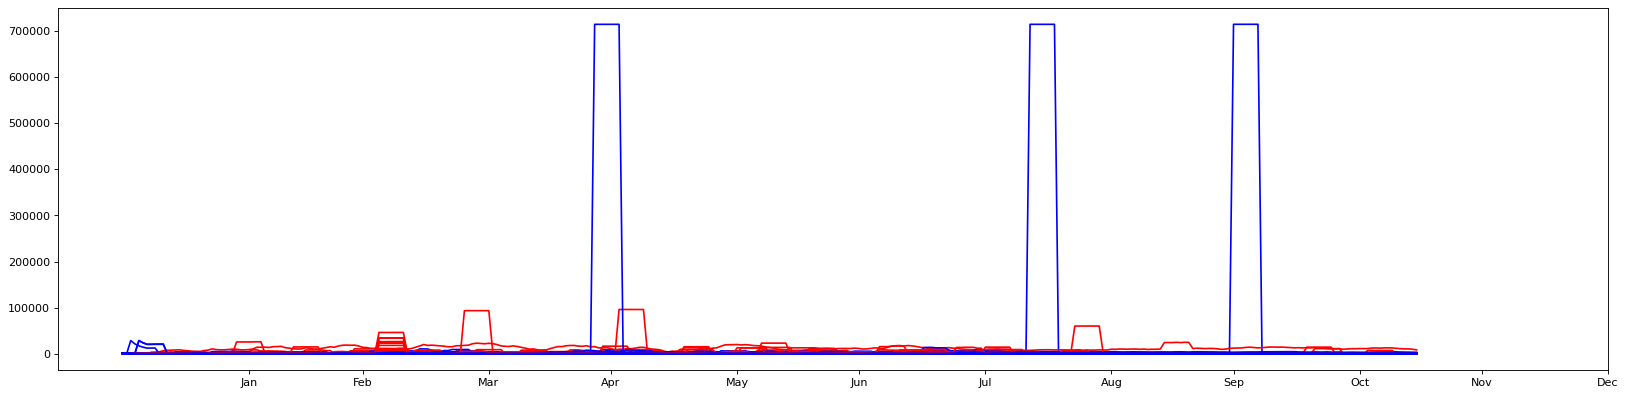

In [ ]:
# plot test set TimeSeries (predicted colors)
figure(figsize=(25, 6), dpi=80)

for i in range(len(X_test)):

  if pred[i] == 0:
    col = "b"
  else:
    col = "r"

  plt.plot(X_test[i], color=col)

#plt.ylim(-1,500000)
plt.xticks([31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

In [ ]:
shp_clf.shapelets_as_time_series_.shape

(6, 31, 1)

In [ ]:
shp_clf.shapelets_[0].shape

(31, 1)

In [ ]:
# Select three shapelets
sel_shapelets = np.asarray([shp_clf.shapelets_[0], 
                        shp_clf.shapelets_[1], 
                        shp_clf.shapelets_[2],
                        shp_clf.shapelets_[3],
                        shp_clf.shapelets_[4],
                        shp_clf.shapelets_[5]])

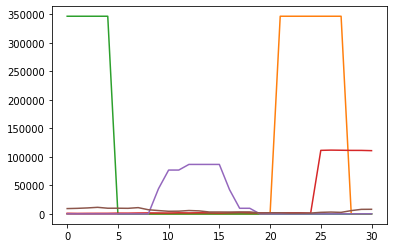

In [ ]:
plt.plot(sel_shapelets[0])
plt.plot(sel_shapelets[1])
plt.plot(sel_shapelets[2])
plt.plot(sel_shapelets[3])
plt.plot(sel_shapelets[4])
plt.plot(sel_shapelets[5])

plt.show()

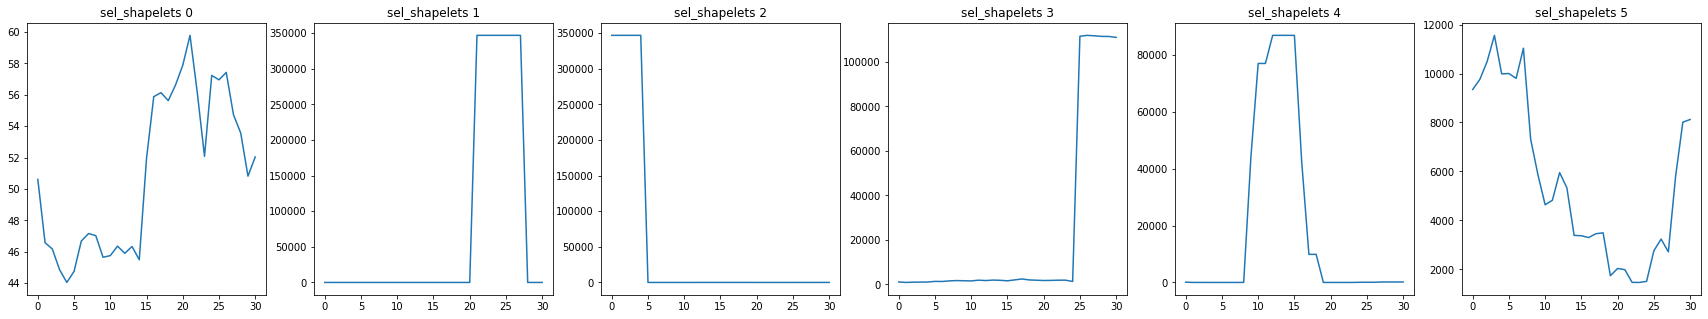

In [ ]:
# sel_shapelets plots
f, axs = plt.subplots(nrows=1, ncols=len(sel_shapelets), figsize=(30,5))

for i in range(len(sel_shapelets)):
    axs[i].plot(sel_shapelets[i])
    axs[i].set_title('sel_shapelets '+ str(i))

plt.show()

# Classification Xwn7

In [ ]:
X = Xwn7

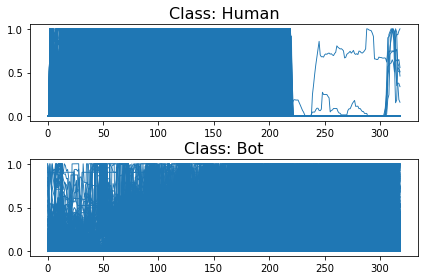

In [ ]:
plt.figure()
for i, classe in enumerate(['Human', 'Bot']):
    plt.subplot(2, 1, i + 1)
    for x in np.array(X)[y == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5429, 319)
(1358, 319)
(5429,)
(1358,)


In [ ]:
# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=X_train.shape[0],
                                                       ts_sz=X_train.shape[1],
                                                       n_classes=2,
                                                       l=0.1,
                                                       r=1)

# Define the model using parameters provided by the authors (except that we
# use fewer iterations here)
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            optimizer=tf.optimizers.Adam(.001), #.001 #
                            batch_size=16,
                           # weight_regularizer=.0001,  # [0.1,0.01, 0.001, 0.0001]
                            max_iter=25,
                            total_lengths=3, #[3, 5]
                            random_state=42,
                            verbose=1)
shp_clf.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Epoch 1/25
340/340 [==============================] - 3s 6ms/step - loss: 0.6861 - binary_accuracy: 0.5714 - binary_crossentropy: 0.6861
Epoch 2/25
340/340 [==============================] - 2s 5ms/step - loss: 0.6669 - binary_accuracy: 0.5712 - binary_crossentropy: 0.6669
Epoch 3/25
340/340 [==============================] - 2s 5ms/step - loss: 0.6429 - binary_accuracy: 0.6191 - binary_crossentropy: 0.6429
Epoch 4/25
340/340 [==============================] - 2s 6ms/step - loss: 0.6251 - binary_accuracy: 0.6511 - binary_crossentropy: 0.6251
Epoch 5/25
340/340 [==============================] - 2s 6ms/step - loss: 0.6142 - binary_accuracy: 0.6587 - binary_crossentropy: 0.6142
Epoch 6/25
340/340 [==============================] - 2s 6ms/step - loss: 0.6078 - binary_accuracy: 0.6596 - binary_crossentropy: 0.6078
Epoch 7/25
340/340 [==============================] - 2s 6ms/step - loss: 0.6043 - binary_accuracy: 0.6651 - binary_crossentropy: 0.6043
Epoch 8/25
340/340 [=====================

LearningShapelets(batch_size=16, max_iter=25, n_shapelets_per_size={31: 6},
                  optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f0a45cff5b0>,
                  random_state=42, verbose=1)

In [ ]:
pred = shp_clf.predict(X_test)

85/85 [==============================] - 0s 4ms/step


In [ ]:
#compute the performance of the model
report_scores(y_test, pred)

              precision    recall  f1-score   support

   human (0)       0.67      0.52      0.58       584
     bot (1)       0.69      0.81      0.74       774

    accuracy                           0.68      1358
   macro avg       0.68      0.66      0.66      1358
weighted avg       0.68      0.68      0.67      1358



In [ ]:
#compute confusion matrix
cm = confusion_matrix(y_test, pred)
cm

array([[303, 281],
       [150, 624]])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


85/85 [==============================] - 0s 4ms/step


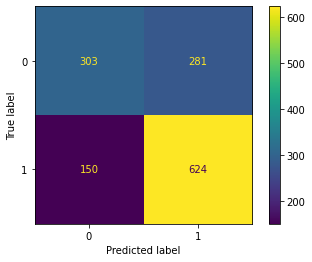

In [ ]:
#it is possible to plot the confusion matrix 
plot_confusion_matrix(shp_clf, X_test, y_test)
plt.show() 

In [ ]:
pred

array([0, 1, 1, ..., 1, 0, 1])

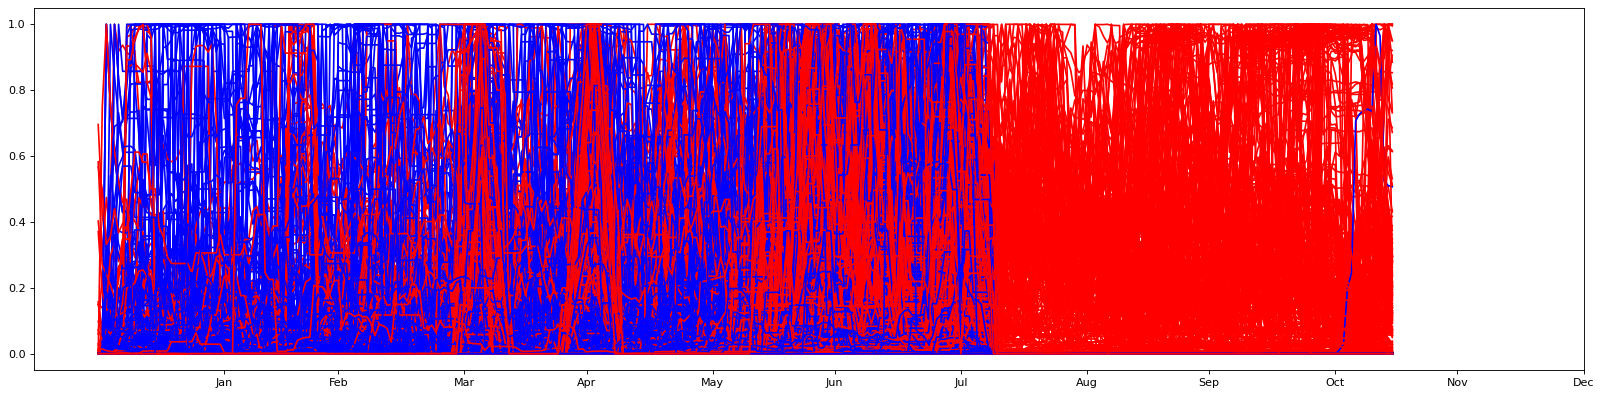

In [ ]:
# plot test set TimeSeries (real colors)
figure(figsize=(25, 6), dpi=80)

for i in range(len(X_test)):

  if y_test[i] == 0:
    col = "b"
  else:
    col = "r"

  plt.plot(X_test[i], color=col)

#plt.ylim(-1,500000)
plt.xticks([31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

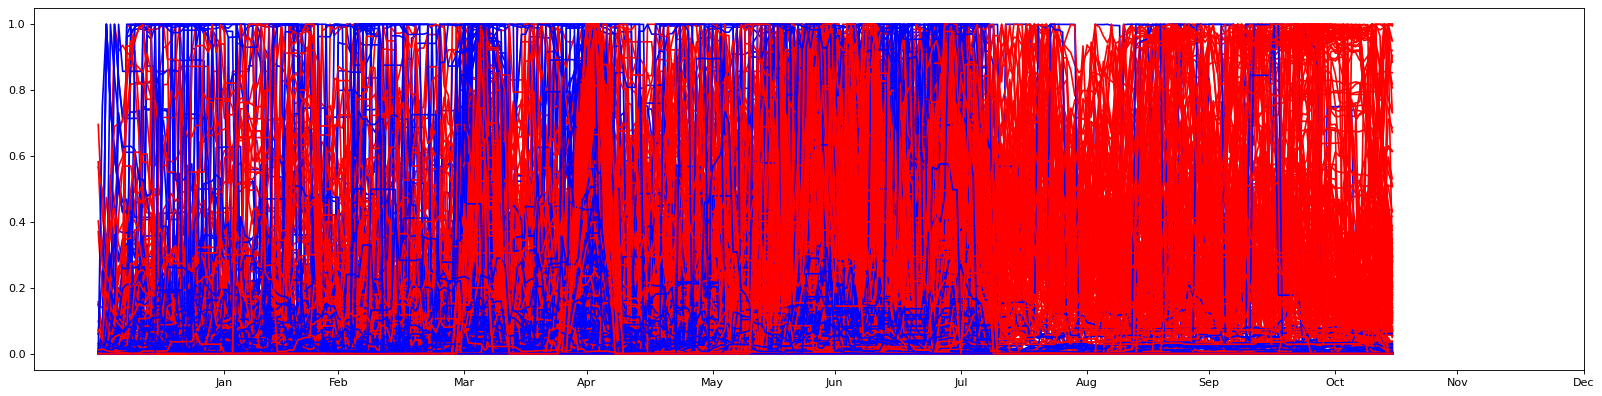

In [ ]:
# plot test set TimeSeries (predicted colors)
figure(figsize=(25, 6), dpi=80)

for i in range(len(X_test)):

  if pred[i] == 0:
    col = "b"
  else:
    col = "r"

  plt.plot(X_test[i], color=col)

#plt.ylim(-1,500000)
plt.xticks([31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

In [ ]:
shp_clf.shapelets_as_time_series_.shape

(6, 31, 1)

In [ ]:
shp_clf.shapelets_[0].shape

(31, 1)

In [ ]:
# Select three shapelets
sel_shapelets = np.asarray([shp_clf.shapelets_[0], 
                        shp_clf.shapelets_[1], 
                        shp_clf.shapelets_[2],
                        shp_clf.shapelets_[3],
                        shp_clf.shapelets_[4],
                        shp_clf.shapelets_[5]])

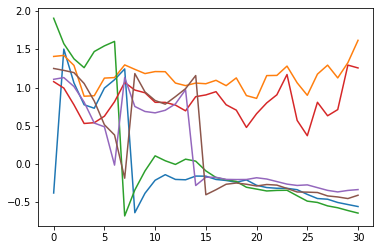

In [ ]:
plt.plot(sel_shapelets[0])
plt.plot(sel_shapelets[1])
plt.plot(sel_shapelets[2])
plt.plot(sel_shapelets[3])
plt.plot(sel_shapelets[4])
plt.plot(sel_shapelets[5])

plt.show()

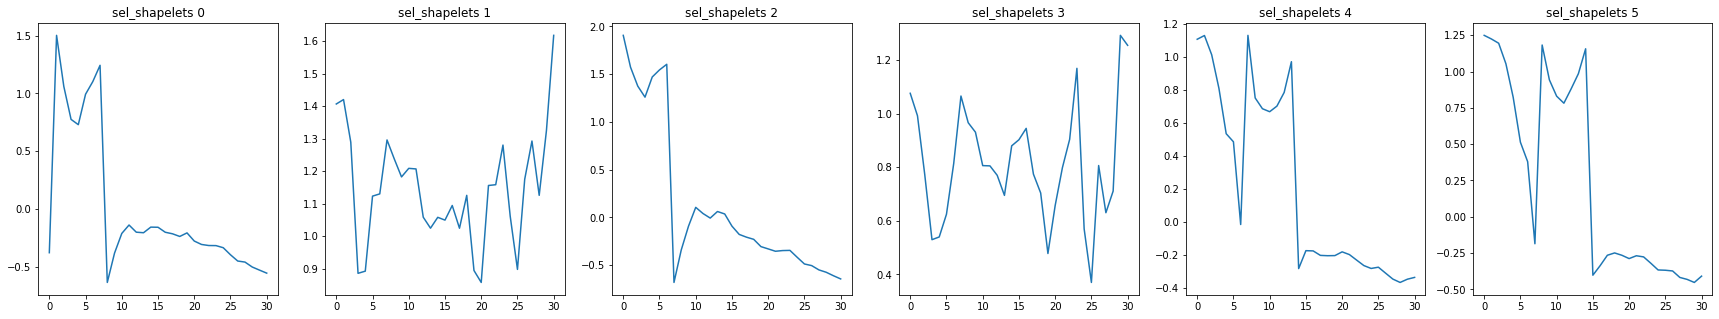

In [ ]:
# sel_shapelets plots
f, axs = plt.subplots(nrows=1, ncols=len(sel_shapelets), figsize=(30,5))

for i in range(len(sel_shapelets)):
    axs[i].plot(sel_shapelets[i])
    axs[i].set_title('sel_shapelets '+ str(i))

plt.show()

# Classification Xw14

In [ ]:
X = Xw14

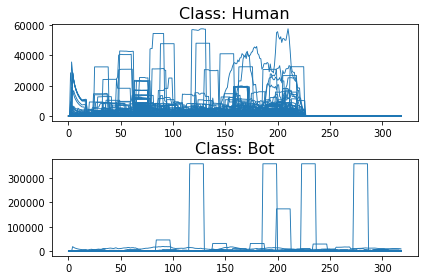

In [ ]:
plt.figure()
for i, classe in enumerate(['Human', 'Bot']):
    plt.subplot(2, 1, i + 1)
    for x in np.array(X)[y == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5429, 319)
(1358, 319)
(5429,)
(1358,)


In [ ]:
# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=X_train.shape[0],
                                                       ts_sz=X_train.shape[1],
                                                       n_classes=2,
                                                       l=0.1,
                                                       r=1)

# Define the model using parameters provided by the authors (except that we
# use fewer iterations here)
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            optimizer=tf.optimizers.Adam(.001), #.001 #
                            batch_size=16,
                           # weight_regularizer=.0001,  # [0.1,0.01, 0.001, 0.0001]
                            max_iter=25,
                            total_lengths=3, #[3, 5]
                            random_state=42,
                            verbose=1)
shp_clf.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Epoch 1/25
340/340 [==============================] - 3s 5ms/step - loss: 1632654208.0000 - binary_accuracy: 0.5712 - binary_crossentropy: 1632654208.0000
Epoch 2/25
340/340 [==============================] - 2s 6ms/step - loss: 8947144.0000 - binary_accuracy: 0.4321 - binary_crossentropy: 8947144.0000
Epoch 3/25
340/340 [==============================] - 2s 6ms/step - loss: 7301486.5000 - binary_accuracy: 0.4375 - binary_crossentropy: 7301486.5000
Epoch 4/25
340/340 [==============================] - 2s 6ms/step - loss: 7580918.0000 - binary_accuracy: 0.4283 - binary_crossentropy: 7580918.0000
Epoch 5/25
340/340 [==============================] - 2s 6ms/step - loss: 7184216.5000 - binary_accuracy: 0.4360 - binary_crossentropy: 7184216.5000
Epoch 6/25
340/340 [==============================] - 2s 6ms/step - loss: 6957421.5000 - binary_accuracy: 0.4470 - binary_crossentropy: 6957421.5000
Epoch 7/25
340/340 [==============================] - 2s 6ms/step - loss: 6824548.5000 - binary_accu

LearningShapelets(batch_size=16, max_iter=25, n_shapelets_per_size={31: 6},
                  optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f0a4796e5b0>,
                  random_state=42, verbose=1)

In [ ]:
pred = shp_clf.predict(X_test)

85/85 [==============================] - 0s 4ms/step


In [ ]:
#compute the performance of the model
report_scores(y_test, pred)

              precision    recall  f1-score   support

   human (0)       0.71      0.12      0.21       584
     bot (1)       0.59      0.96      0.73       774

    accuracy                           0.60      1358
   macro avg       0.65      0.54      0.47      1358
weighted avg       0.64      0.60      0.51      1358



In [ ]:
#compute confusion matrix
cm = confusion_matrix(y_test, pred)
cm

array([[ 71, 513],
       [ 29, 745]])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


85/85 [==============================] - 0s 3ms/step


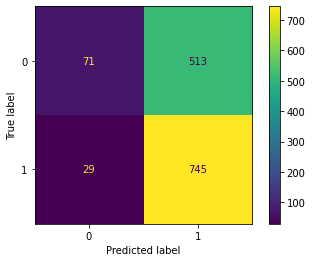

In [ ]:
#it is possible to plot the confusion matrix 
plot_confusion_matrix(shp_clf, X_test, y_test)
plt.show() 

In [ ]:
pred

array([1, 0, 1, ..., 1, 1, 1])

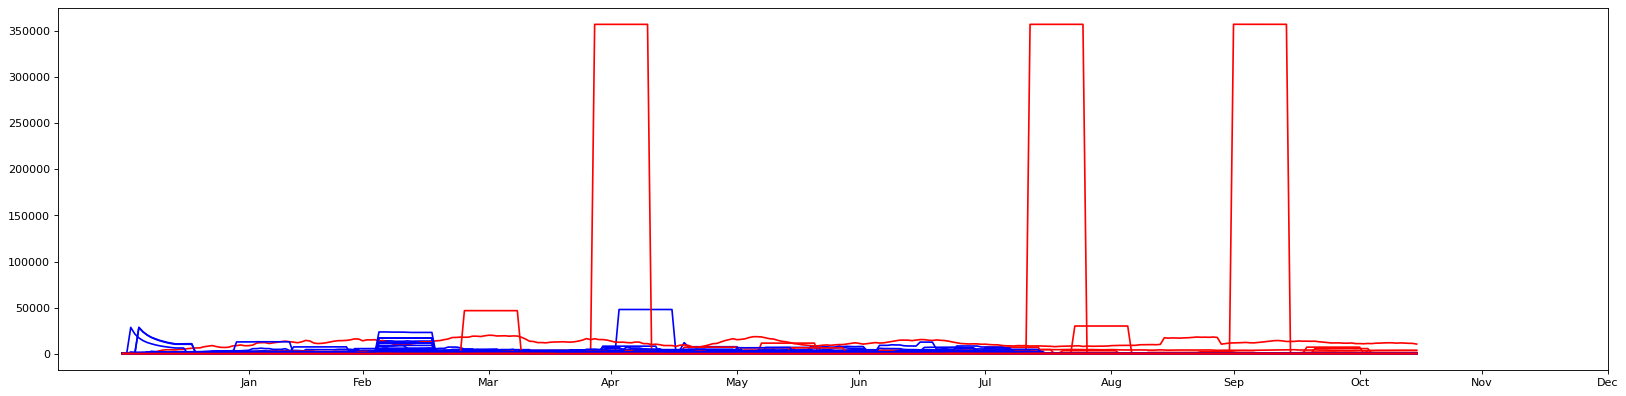

In [ ]:
# plot test set TimeSeries (real colors)
figure(figsize=(25, 6), dpi=80)

for i in range(len(X_test)):

  if y_test[i] == 0:
    col = "b"
  else:
    col = "r"

  plt.plot(X_test[i], color=col)

#plt.ylim(-1,500000)
plt.xticks([31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

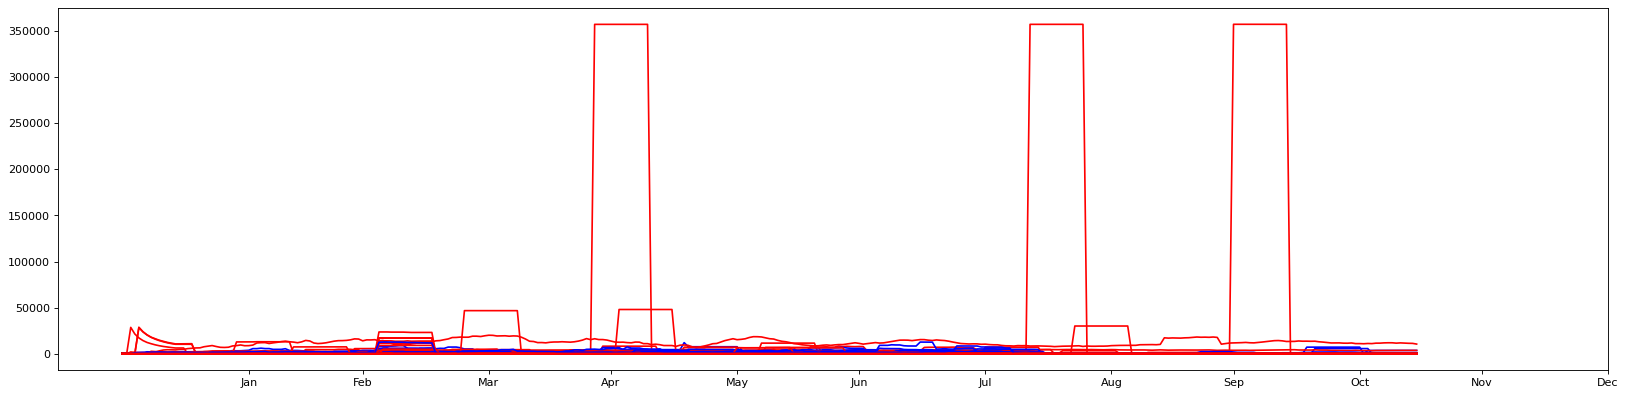

In [ ]:
# plot test set TimeSeries (predicted colors)
figure(figsize=(25, 6), dpi=80)

for i in range(len(X_test)):

  if pred[i] == 0:
    col = "b"
  else:
    col = "r"

  plt.plot(X_test[i], color=col)

#plt.ylim(-1,500000)
plt.xticks([31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

In [ ]:
shp_clf.shapelets_as_time_series_.shape

(6, 31, 1)

In [ ]:
shp_clf.shapelets_[0].shape

(31, 1)

In [ ]:
# Select three shapelets
sel_shapelets = np.asarray([shp_clf.shapelets_[0], 
                        shp_clf.shapelets_[1], 
                        shp_clf.shapelets_[2],
                        shp_clf.shapelets_[3],
                        shp_clf.shapelets_[4],
                        shp_clf.shapelets_[5]])

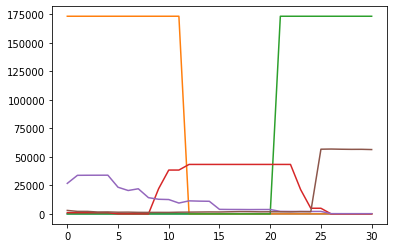

In [ ]:
plt.plot(sel_shapelets[0])
plt.plot(sel_shapelets[1])
plt.plot(sel_shapelets[2])
plt.plot(sel_shapelets[3])
plt.plot(sel_shapelets[4])
plt.plot(sel_shapelets[5])

plt.show()

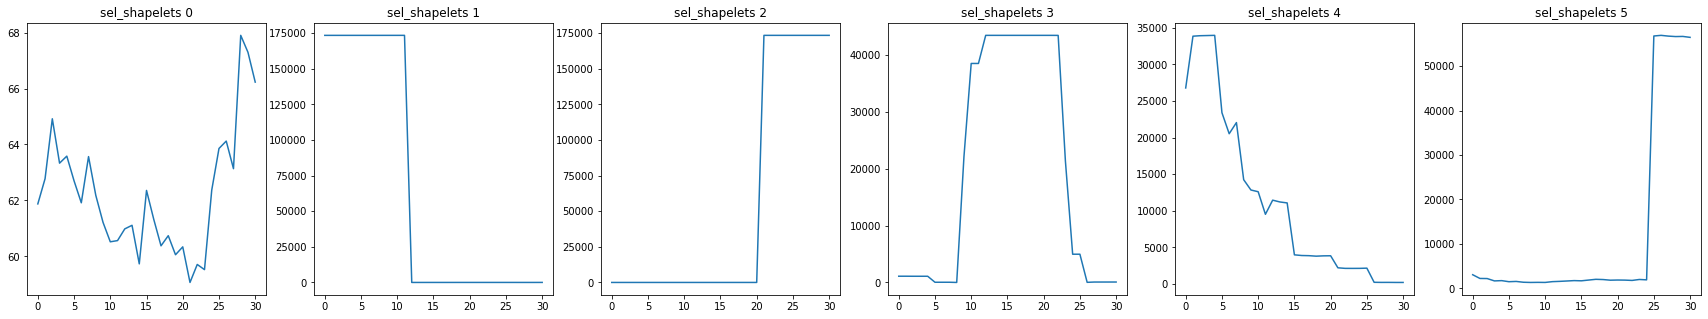

In [ ]:
# sel_shapelets plots
f, axs = plt.subplots(nrows=1, ncols=len(sel_shapelets), figsize=(30,5))

for i in range(len(sel_shapelets)):
    axs[i].plot(sel_shapelets[i])
    axs[i].set_title('sel_shapelets '+ str(i))

plt.show()

# Classification Xwn14

In [ ]:
X = Xwn14

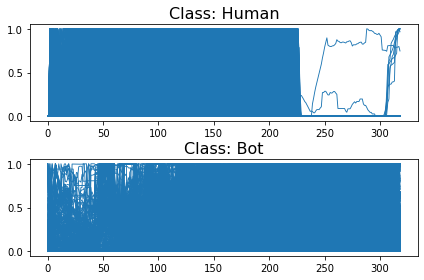

In [ ]:
plt.figure()
for i, classe in enumerate(['Human', 'Bot']):
    plt.subplot(2, 1, i + 1)
    for x in np.array(X)[y == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5429, 319)
(1358, 319)
(5429,)
(1358,)


In [ ]:
# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=X_train.shape[0],
                                                       ts_sz=X_train.shape[1],
                                                       n_classes=2,
                                                       l=0.1,
                                                       r=1)

# Define the model using parameters provided by the authors (except that we
# use fewer iterations here)
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            optimizer=tf.optimizers.Adam(.001), #.001 #
                            batch_size=16,
                           # weight_regularizer=.0001,  # [0.1,0.01, 0.001, 0.0001]
                            max_iter=25,
                            total_lengths=3, #[3, 5]
                            random_state=42,
                            verbose=1)
shp_clf.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Epoch 1/25
340/340 [==============================] - 3s 6ms/step - loss: 0.6775 - binary_accuracy: 0.5714 - binary_crossentropy: 0.6775
Epoch 2/25
340/340 [==============================] - 2s 6ms/step - loss: 0.6546 - binary_accuracy: 0.5874 - binary_crossentropy: 0.6546
Epoch 3/25
340/340 [==============================] - 2s 6ms/step - loss: 0.6344 - binary_accuracy: 0.6412 - binary_crossentropy: 0.6344
Epoch 4/25
340/340 [==============================] - 2s 6ms/step - loss: 0.6204 - binary_accuracy: 0.6526 - binary_crossentropy: 0.6204
Epoch 5/25
340/340 [==============================] - 2s 6ms/step - loss: 0.6105 - binary_accuracy: 0.6631 - binary_crossentropy: 0.6105
Epoch 6/25
340/340 [==============================] - 2s 6ms/step - loss: 0.6039 - binary_accuracy: 0.6664 - binary_crossentropy: 0.6039
Epoch 7/25
340/340 [==============================] - 2s 6ms/step - loss: 0.5992 - binary_accuracy: 0.6690 - binary_crossentropy: 0.5992
Epoch 8/25
340/340 [=====================

LearningShapelets(batch_size=16, max_iter=25, n_shapelets_per_size={31: 6},
                  optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f0a44cb1ac0>,
                  random_state=42, verbose=1)

In [ ]:
pred = shp_clf.predict(X_test)

85/85 [==============================] - 0s 4ms/step


In [ ]:
#compute the performance of the model
report_scores(y_test, pred)

              precision    recall  f1-score   support

   human (0)       0.69      0.51      0.59       584
     bot (1)       0.69      0.83      0.75       774

    accuracy                           0.69      1358
   macro avg       0.69      0.67      0.67      1358
weighted avg       0.69      0.69      0.68      1358



In [ ]:
#compute confusion matrix
cm = confusion_matrix(y_test, pred)
cm

array([[296, 288],
       [131, 643]])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


85/85 [==============================] - 0s 4ms/step


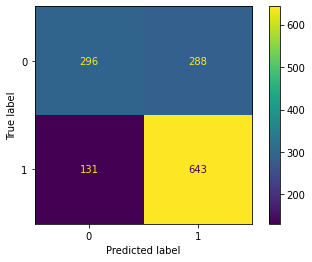

In [ ]:
#it is possible to plot the confusion matrix 
plot_confusion_matrix(shp_clf, X_test, y_test)
plt.show() 

In [ ]:
pred

array([0, 1, 1, ..., 1, 0, 1])

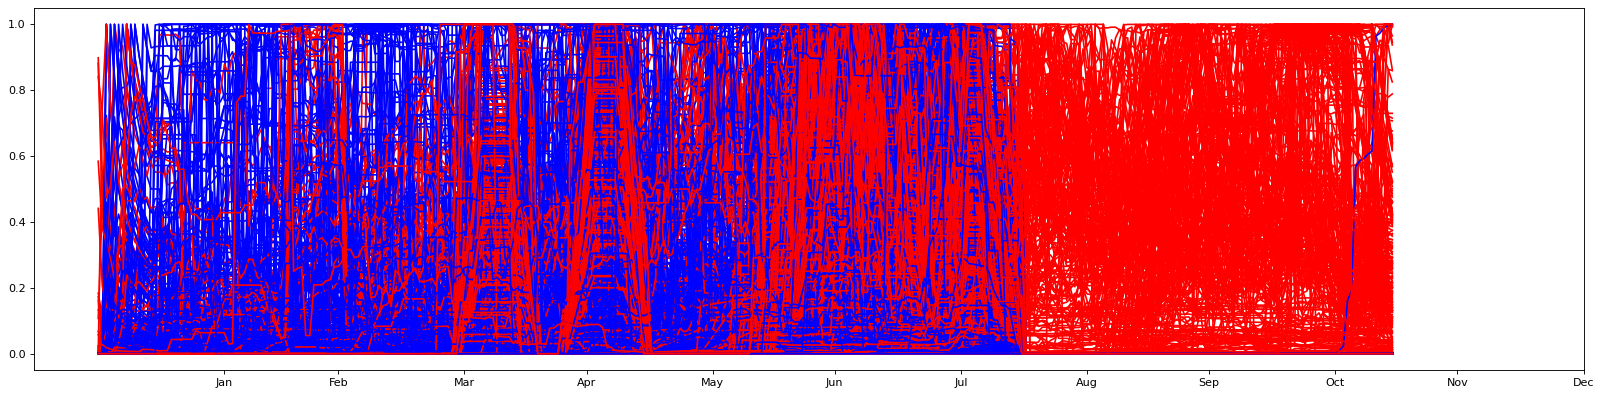

In [ ]:
# plot test set TimeSeries (real colors)
figure(figsize=(25, 6), dpi=80)

for i in range(len(X_test)):

  if y_test[i] == 0:
    col = "b"
  else:
    col = "r"

  plt.plot(X_test[i], color=col)

#plt.ylim(-1,500000)
plt.xticks([31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

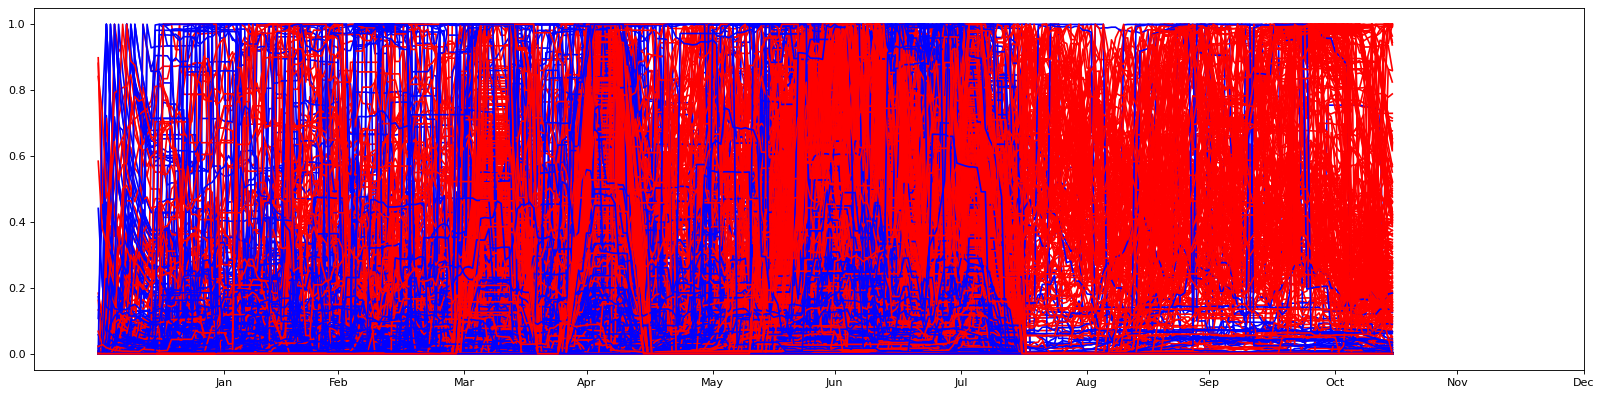

In [ ]:
# plot test set TimeSeries (predicted colors)
figure(figsize=(25, 6), dpi=80)

for i in range(len(X_test)):

  if pred[i] == 0:
    col = "b"
  else:
    col = "r"

  plt.plot(X_test[i], color=col)

#plt.ylim(-1,500000)
plt.xticks([31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

In [ ]:
shp_clf.shapelets_as_time_series_.shape

(6, 31, 1)

In [ ]:
shp_clf.shapelets_[0].shape

(31, 1)

In [ ]:
# Select three shapelets
sel_shapelets = np.asarray([shp_clf.shapelets_[0], 
                        shp_clf.shapelets_[1], 
                        shp_clf.shapelets_[2],
                        shp_clf.shapelets_[3],
                        shp_clf.shapelets_[4],
                        shp_clf.shapelets_[5]])

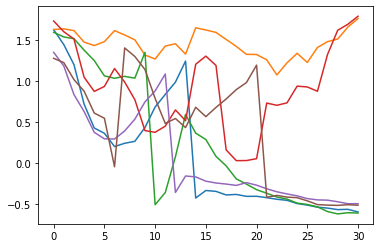

In [ ]:
plt.plot(sel_shapelets[0])
plt.plot(sel_shapelets[1])
plt.plot(sel_shapelets[2])
plt.plot(sel_shapelets[3])
plt.plot(sel_shapelets[4])
plt.plot(sel_shapelets[5])

plt.show()

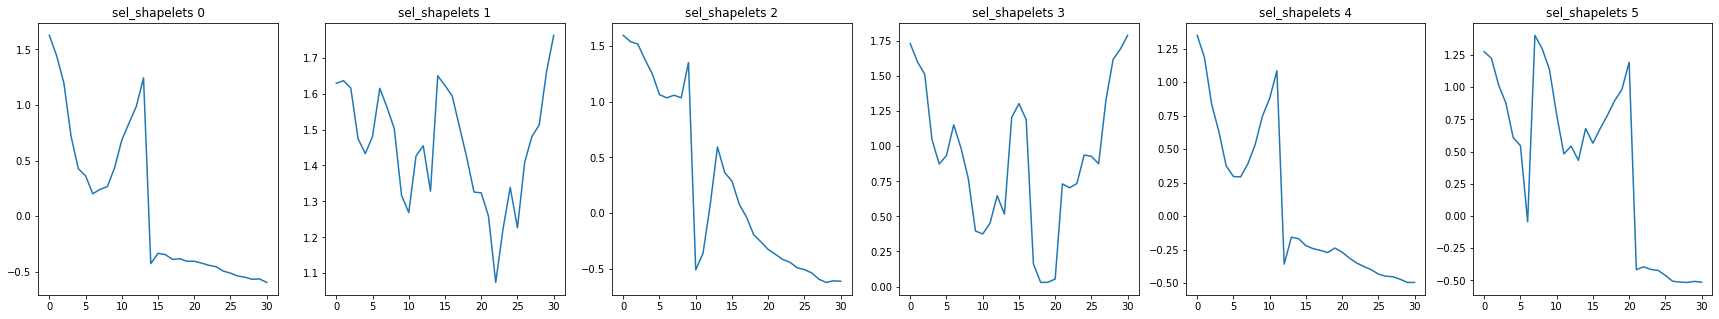

In [ ]:
# sel_shapelets plots
f, axs = plt.subplots(nrows=1, ncols=len(sel_shapelets), figsize=(30,5))

for i in range(len(sel_shapelets)):
    axs[i].plot(sel_shapelets[i])
    axs[i].set_title('sel_shapelets '+ str(i))

plt.show()

# Classification Xw30

In [ ]:
X = Xw30

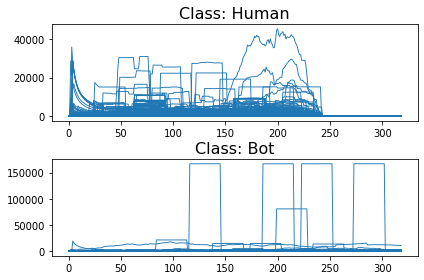

In [ ]:
plt.figure()
for i, classe in enumerate(['Human', 'Bot']):
    plt.subplot(2, 1, i + 1)
    for x in np.array(X)[y == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5429, 319)
(1358, 319)
(5429,)
(1358,)


In [ ]:
# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=X_train.shape[0],
                                                       ts_sz=X_train.shape[1],
                                                       n_classes=2,
                                                       l=0.1,
                                                       r=1)

# Define the model using parameters provided by the authors (except that we
# use fewer iterations here)
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            optimizer=tf.optimizers.Adam(.001), #.001 #
                            batch_size=16,
                           # weight_regularizer=.0001,  # [0.1,0.01, 0.001, 0.0001]
                            max_iter=25,
                            total_lengths=3, #[3, 5]
                            random_state=42,
                            verbose=1)
shp_clf.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Epoch 1/25
340/340 [==============================] - 3s 6ms/step - loss: 60825352.0000 - binary_accuracy: 0.5738 - binary_crossentropy: 60825352.0000
Epoch 2/25
340/340 [==============================] - 2s 6ms/step - loss: 1482150.7500 - binary_accuracy: 0.6174 - binary_crossentropy: 1482150.7500
Epoch 3/25
340/340 [==============================] - 2s 6ms/step - loss: 1592554.8750 - binary_accuracy: 0.6143 - binary_crossentropy: 1592554.8750
Epoch 4/25
340/340 [==============================] - 2s 6ms/step - loss: 1541264.6250 - binary_accuracy: 0.6174 - binary_crossentropy: 1541264.6250
Epoch 5/25
340/340 [==============================] - 2s 6ms/step - loss: 1702916.5000 - binary_accuracy: 0.6191 - binary_crossentropy: 1702916.5000
Epoch 6/25
340/340 [==============================] - 2s 6ms/step - loss: 1637262.1250 - binary_accuracy: 0.6137 - binary_crossentropy: 1637262.1250
Epoch 7/25
340/340 [==============================] - 2s 6ms/step - loss: 1691216.1250 - binary_accuracy

LearningShapelets(batch_size=16, max_iter=25, n_shapelets_per_size={31: 6},
                  optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f0a3577fd90>,
                  random_state=42, verbose=1)

In [ ]:
pred = shp_clf.predict(X_test)

85/85 [==============================] - 0s 3ms/step


In [ ]:
#compute the performance of the model
report_scores(y_test, pred)

              precision    recall  f1-score   support

   human (0)       0.69      0.41      0.51       584
     bot (1)       0.66      0.86      0.75       774

    accuracy                           0.67      1358
   macro avg       0.67      0.63      0.63      1358
weighted avg       0.67      0.67      0.64      1358



In [ ]:
#compute confusion matrix
cm = confusion_matrix(y_test, pred)
cm

array([[237, 347],
       [107, 667]])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


85/85 [==============================] - 0s 4ms/step


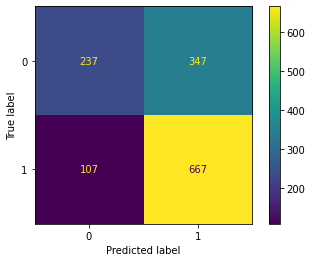

In [ ]:
#it is possible to plot the confusion matrix 
plot_confusion_matrix(shp_clf, X_test, y_test)
plt.show() 

In [ ]:
pred

array([1, 0, 1, ..., 1, 1, 1])

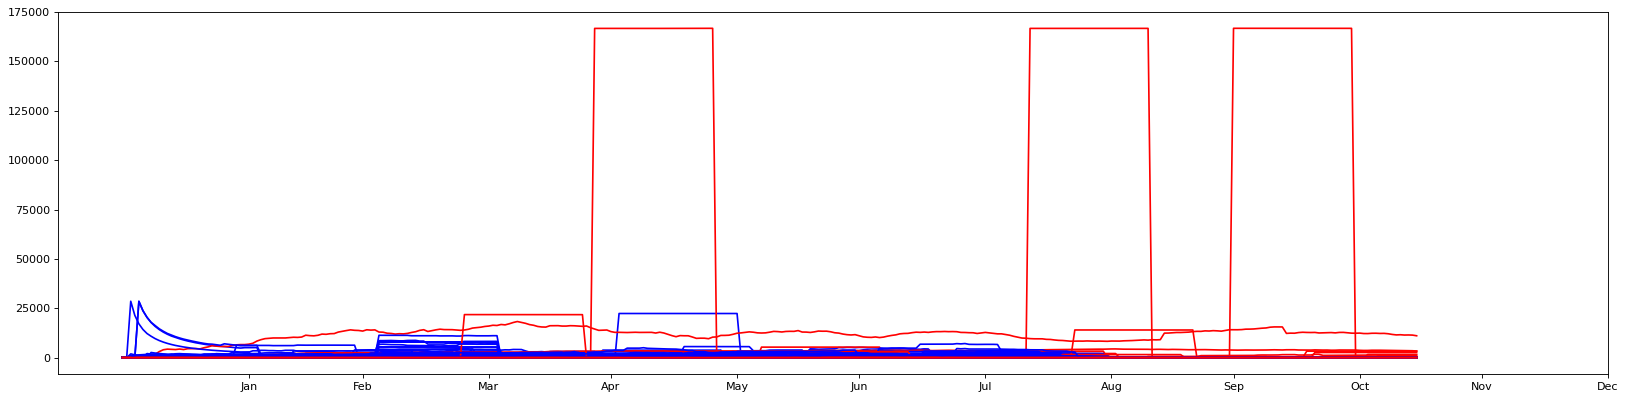

In [ ]:
# plot test set TimeSeries (real colors)
figure(figsize=(25, 6), dpi=80)

for i in range(len(X_test)):

  if y_test[i] == 0:
    col = "b"
  else:
    col = "r"

  plt.plot(X_test[i], color=col)

#plt.ylim(-1,500000)
plt.xticks([31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

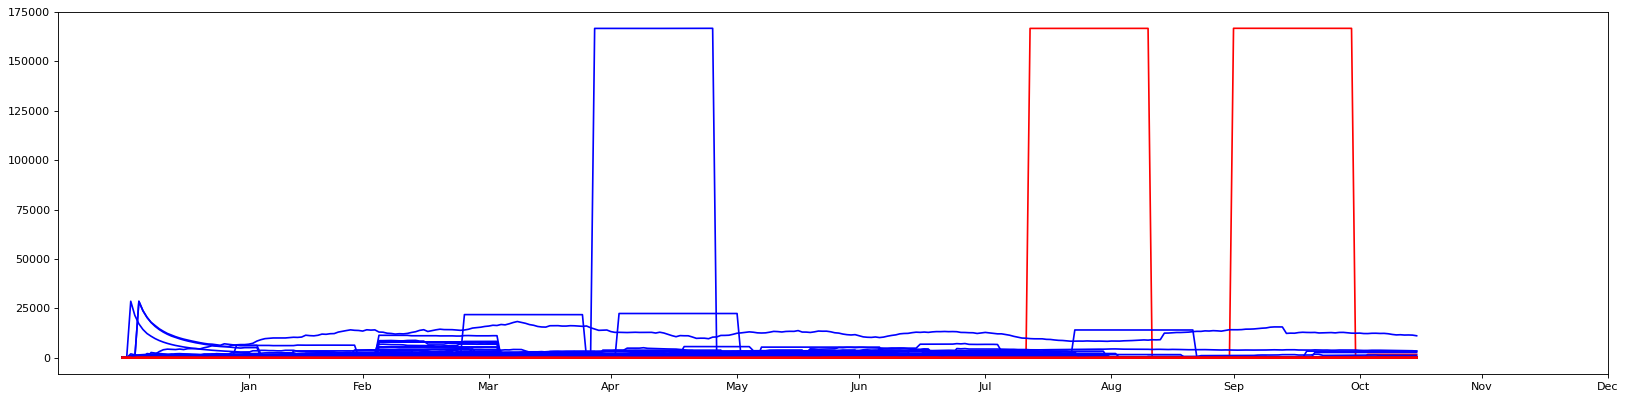

In [ ]:
# plot test set TimeSeries (predicted colors)
figure(figsize=(25, 6), dpi=80)

for i in range(len(X_test)):

  if pred[i] == 0:
    col = "b"
  else:
    col = "r"

  plt.plot(X_test[i], color=col)

#plt.ylim(-1,500000)
plt.xticks([31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

In [ ]:
shp_clf.shapelets_as_time_series_.shape

(6, 31, 1)

In [ ]:
shp_clf.shapelets_[0].shape

(31, 1)

In [ ]:
# Select three shapelets
sel_shapelets = np.asarray([shp_clf.shapelets_[0], 
                        shp_clf.shapelets_[1], 
                        shp_clf.shapelets_[2],
                        shp_clf.shapelets_[3],
                        shp_clf.shapelets_[4],
                        shp_clf.shapelets_[5]])

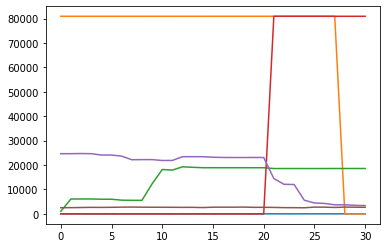

In [ ]:
plt.plot(sel_shapelets[0])
plt.plot(sel_shapelets[1])
plt.plot(sel_shapelets[2])
plt.plot(sel_shapelets[3])
plt.plot(sel_shapelets[4])
plt.plot(sel_shapelets[5])

plt.show()

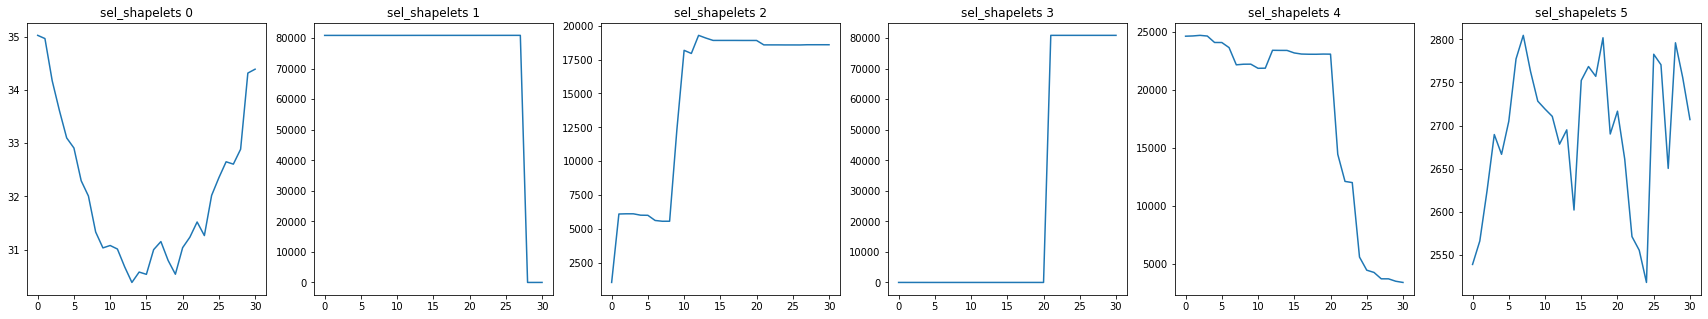

In [ ]:
# sel_shapelets plots
f, axs = plt.subplots(nrows=1, ncols=len(sel_shapelets), figsize=(30,5))

for i in range(len(sel_shapelets)):
    axs[i].plot(sel_shapelets[i])
    axs[i].set_title('sel_shapelets '+ str(i))

plt.show()

# Classification Xwn30

In [ ]:
X = Xwn30

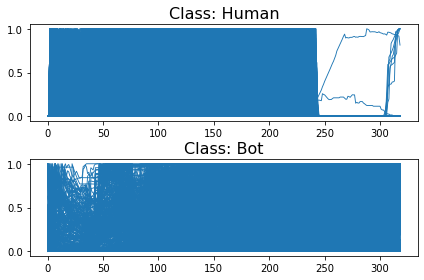

In [ ]:
plt.figure()
for i, classe in enumerate(['Human', 'Bot']):
    plt.subplot(2, 1, i + 1)
    for x in np.array(X)[y == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5429, 319)
(1358, 319)
(5429,)
(1358,)


In [ ]:
# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=X_train.shape[0],
                                                       ts_sz=X_train.shape[1],
                                                       n_classes=2,
                                                       l=0.1,
                                                       r=1)

# Define the model using parameters provided by the authors (except that we
# use fewer iterations here)
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            optimizer=tf.optimizers.Adam(.001), #.001 #
                            batch_size=16,
                           # weight_regularizer=.0001,  # [0.1,0.01, 0.001, 0.0001]
                            max_iter=25,
                            total_lengths=3, #[3, 5]
                            random_state=42,
                            verbose=1)
shp_clf.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Epoch 1/25
340/340 [==============================] - 3s 6ms/step - loss: 0.6823 - binary_accuracy: 0.5714 - binary_crossentropy: 0.6823
Epoch 2/25
340/340 [==============================] - 2s 6ms/step - loss: 0.6607 - binary_accuracy: 0.5712 - binary_crossentropy: 0.6607
Epoch 3/25
340/340 [==============================] - 2s 5ms/step - loss: 0.6445 - binary_accuracy: 0.6042 - binary_crossentropy: 0.6445
Epoch 4/25
340/340 [==============================] - 2s 5ms/step - loss: 0.6344 - binary_accuracy: 0.6217 - binary_crossentropy: 0.6344
Epoch 5/25
340/340 [==============================] - 2s 5ms/step - loss: 0.6239 - binary_accuracy: 0.6347 - binary_crossentropy: 0.6239
Epoch 6/25
340/340 [==============================] - 2s 5ms/step - loss: 0.6141 - binary_accuracy: 0.6495 - binary_crossentropy: 0.6141
Epoch 7/25
340/340 [==============================] - 2s 6ms/step - loss: 0.6073 - binary_accuracy: 0.6585 - binary_crossentropy: 0.6073
Epoch 8/25
340/340 [=====================

LearningShapelets(batch_size=16, max_iter=25, n_shapelets_per_size={31: 6},
                  optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f0a475f6b80>,
                  random_state=42, verbose=1)

In [ ]:
pred = shp_clf.predict(X_test)

85/85 [==============================] - 0s 4ms/step


In [ ]:
#compute the performance of the model
report_scores(y_test, pred)

              precision    recall  f1-score   support

   human (0)       0.68      0.45      0.54       584
     bot (1)       0.67      0.84      0.75       774

    accuracy                           0.67      1358
   macro avg       0.67      0.65      0.64      1358
weighted avg       0.67      0.67      0.66      1358



In [ ]:
#compute confusion matrix
cm = confusion_matrix(y_test, pred)
cm

array([[265, 319],
       [125, 649]])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


85/85 [==============================] - 0s 4ms/step


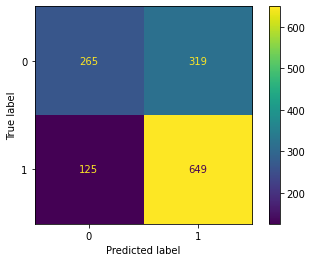

In [ ]:
#it is possible to plot the confusion matrix 
plot_confusion_matrix(shp_clf, X_test, y_test)
plt.show() 

In [ ]:
pred

array([0, 1, 1, ..., 1, 1, 1])

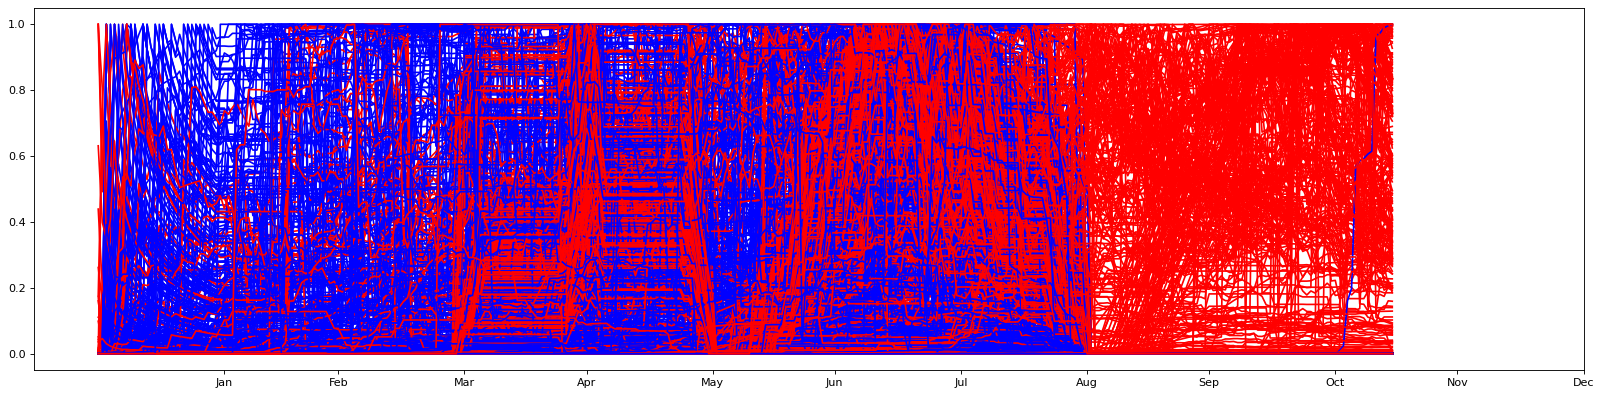

In [ ]:
# plot test set TimeSeries (real colors)
figure(figsize=(25, 6), dpi=80)

for i in range(len(X_test)):

  if y_test[i] == 0:
    col = "b"
  else:
    col = "r"

  plt.plot(X_test[i], color=col)

#plt.ylim(-1,500000)
plt.xticks([31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

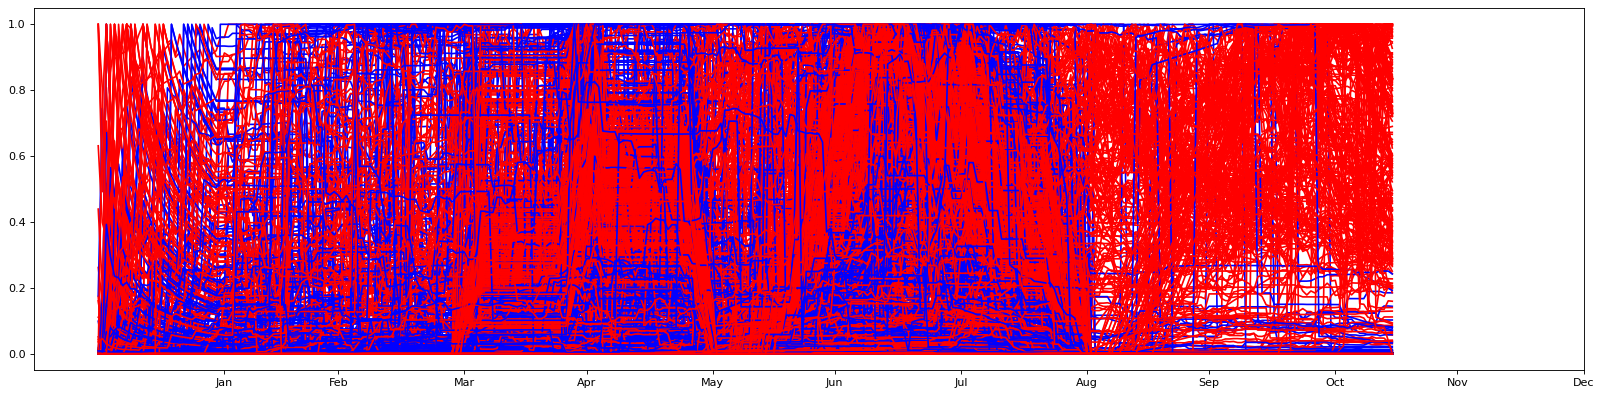

In [ ]:
# plot test set TimeSeries (predicted colors)
figure(figsize=(25, 6), dpi=80)

for i in range(len(X_test)):

  if pred[i] == 0:
    col = "b"
  else:
    col = "r"

  plt.plot(X_test[i], color=col)

#plt.ylim(-1,500000)
plt.xticks([31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

In [ ]:
shp_clf.shapelets_as_time_series_.shape

(6, 31, 1)

In [ ]:
shp_clf.shapelets_[0].shape

(31, 1)

In [ ]:
# Select three shapelets
sel_shapelets = np.asarray([shp_clf.shapelets_[0], 
                        shp_clf.shapelets_[1], 
                        shp_clf.shapelets_[2],
                        shp_clf.shapelets_[3],
                        shp_clf.shapelets_[4],
                        shp_clf.shapelets_[5]])

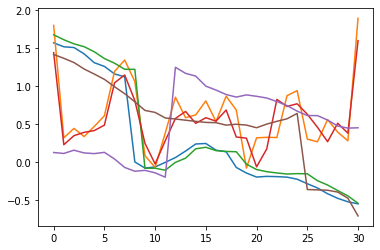

In [ ]:
plt.plot(sel_shapelets[0])
plt.plot(sel_shapelets[1])
plt.plot(sel_shapelets[2])
plt.plot(sel_shapelets[3])
plt.plot(sel_shapelets[4])
plt.plot(sel_shapelets[5])

plt.show()

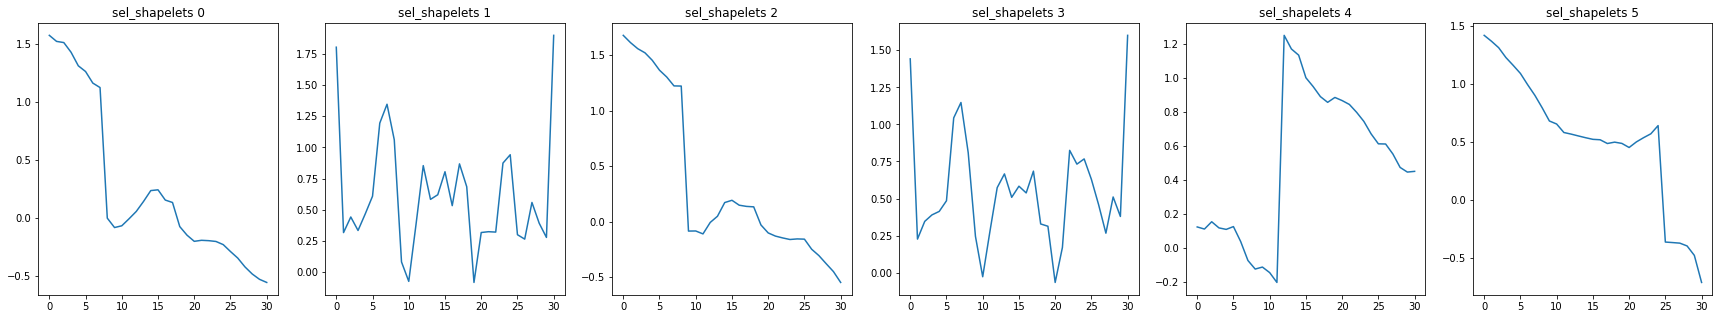

In [ ]:
# sel_shapelets plots
f, axs = plt.subplots(nrows=1, ncols=len(sel_shapelets), figsize=(30,5))

for i in range(len(sel_shapelets)):
    axs[i].plot(sel_shapelets[i])
    axs[i].set_title('sel_shapelets '+ str(i))

plt.show()